In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

# !pip install ControlBurn==0.0.9
from ControlBurn.ControlBurn import ControlBurnClassifier


# Load wine dataset

In [7]:
# wine_train_df = pd.read_csv("datasets/benchmark/wine_train.csv")
# wine_train_df["quality"] = wine_train_df["quality"].astype(int)
# wine_train_df.to_csv("datasets/benchmark/wine_train.csv", index=False)

wine_train_df = pd.read_csv("datasets/benchmark/wine_train.csv")

X_wine_train = wine_train_df.loc[:, wine_train_df.columns != "quality"]
Y_wine_train = wine_train_df["quality"]

wine_test_df = pd.read_csv("datasets/benchmark/wine_test.csv")
X_wine_test = wine_test_df.loc[:, wine_test_df.columns != "quality"]
Y_wine_test = wine_test_df["quality"]

# Load Titanic Dataset

In [123]:
titanic_train_df = pd.read_csv("datasets/benchmark/titanic_clean_train.csv")
X_titanic_train = titanic_train_df.loc[:, titanic_train_df.columns != "Survived"]
Y_titanic_train = titanic_train_df["Survived"]

titanic_test_df = pd.read_csv("datasets/benchmark/titanic_clean_test.csv")
X_titanic_test = titanic_test_df.loc[:, titanic_test_df.columns != "Survived"]
Y_titanic_test = titanic_test_df["Survived"]

# Load Adult Dataset

In [131]:
adult_train_df = pd.read_csv("datasets/benchmark/adult_clean_train.csv")
X_adult_train = adult_train_df.loc[:, adult_train_df.columns != "income_>50k"]
country_filter = [ not "native_country" in x for x in X_adult_train.columns]
X_adult_train = X_adult_train.loc[:, country_filter]
Y_adult_train = adult_train_df["income_>50k"]

adult_test_df = pd.read_csv("datasets/benchmark/adult_clean_test.csv")
X_adult_test = adult_test_df.loc[:, adult_test_df.columns != "income_>50k"]
X_adult_test = X_adult_test.loc[:, country_filter]
Y_adult_test = adult_test_df["income_>50k"]

# Load Weather Aus Dataset

In [147]:
weatherAUS_train_df = pd.read_csv("datasets/benchmark/weatherAUS_clean_train.csv")
X_weatherAUS_train = weatherAUS_train_df.loc[:, weatherAUS_train_df.columns != "RainTomorrow"]
Y_weatherAUS_train = weatherAUS_train_df["RainTomorrow"]

weatherAUS_test_df = pd.read_csv("datasets/benchmark/weatherAUS_clean_test.csv")
X_weatherAUS_test = weatherAUS_test_df.loc[:, weatherAUS_test_df.columns != "RainTomorrow"]
Y_weatherAUS_test = weatherAUS_test_df["RainTomorrow"]

In [149]:
Y_weatherAUS_train.describe()

count    97432.000000
mean         0.221847
std          0.415491
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: RainTomorrow, dtype: float64

# Helper Functions

In [182]:
def square_loss(y_true, y_pred):
    n = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / n

def rank_feature_importance(feature_name, feature_score):
    n = len(feature_name)
    lst = [(feature_name[i], feature_score[i]) for i in range(n)]
    lst.sort(key=lambda x:x[1], reverse=True)
    # uncomment to see just the rank without the score
    # return [x[0] for x in lst]
    return lst

def select_features_filter(all_features, target_features):
    lst = []
    for i in range(len(all_features)):
        if all_features[i] in target_features:
            lst.append(True)
        else:
            lst.append(False)
    return lst

def gen_graph(X_train, X_test, all_features, ranked_features, min_features, max_features, Y_train, Y_test, dataset_name, is_LASSO, negAcc = False):
    # when is_LASSO = true
    # ranked_features = [[feature set 1], [feature set 2], ...]

    # when is_LASSO = false
    # ranked_features = [ f1, f2, f3, ...] ranked by importance
    if is_LASSO:
        n = len(ranked_features)
    else:
        n = max_features + 1 - min_features
    num_estimators = 100
    rf_acc_lst = []
    rf_f1_lst = []

    ridge_acc_lst = []
    ridge_f1_lst = []

    if negAcc:
        neg_rf_f1_lst = []
        neg_ridge_f1_lst = []


    # generate RF baseline
    rf_clf = RandomForestClassifier(random_state=1, n_estimators=num_estimators)
    rf_clf.fit(X_train, Y_train)
    rf_Y_pred = rf_clf.predict(X_test)
    rf_acc_baseline = accuracy_score(Y_test, rf_Y_pred)
    rf_acc_baseline_arr = np.ones(n) * rf_acc_baseline
    rf_f1_baseline = f1_score(Y_test, rf_Y_pred)
    rf_f1_baseline_arr = np.ones(n) * rf_f1_baseline

    # generate Ridge baseline
    ridge_clf = RidgeClassifier()
    ridge_clf.fit(X_train, Y_train)
    ridge_Y_pred = ridge_clf.predict(X_test)
    ridge_acc_baseline = accuracy_score(Y_test, ridge_Y_pred)
    ridge_acc_baseline_arr = np.ones(n) * ridge_acc_baseline
    ridge_f1_baseline = f1_score(Y_test, ridge_Y_pred)
    ridge_f1_baseline_arr = np.ones(n) * ridge_f1_baseline

    
    if negAcc:
        neg_rf_f1_baseline = f1_score(1 - Y_test, 1 - rf_Y_pred)
        neg_rf_f1_baseline_arr = np.ones(n) * neg_rf_f1_baseline

        neg_ridge_f1_baseline = f1_score(1 - Y_test, 1 - ridge_Y_pred)
        neg_ridge_f1_baseline_arr = np.ones(n) * neg_ridge_f1_baseline
    
    n = max_features + 1 - min_features

    if is_LASSO:
        loop_elements = ranked_features
    else:
        loop_elements = np.arange(min_features, max_features + 1)


    for e in loop_elements:
        if is_LASSO:
            target_features = e
        else:
            target_features = ranked_features[:e]
        features_filter = select_features_filter(all_features, target_features)
        selected_X_train = X_train.loc[:, features_filter]
        selected_X_test = X_test.loc[:, features_filter]
        
        # random forest
        rf_clf = RandomForestClassifier(random_state=1, n_estimators=num_estimators)
        rf_clf.fit(selected_X_train, Y_train)
        rf_Y_pred = rf_clf.predict(selected_X_test)

        rf_acc = accuracy_score(Y_test, rf_Y_pred)
        rf_f1 = f1_score(Y_test, rf_Y_pred)
        rf_acc_lst.append(rf_acc)
        rf_f1_lst.append(rf_f1)

        # ridge
        ridge_clf = RidgeClassifier()
        ridge_clf.fit(selected_X_train, Y_train)
        ridge_Y_pred = ridge_clf.predict(selected_X_test)

        ridge_acc = accuracy_score(Y_test, ridge_Y_pred)
        ridge_f1 = f1_score(Y_test, ridge_Y_pred)
        ridge_acc_lst.append(ridge_acc)
        ridge_f1_lst.append(ridge_f1)

        if negAcc:
            neg_rf_f1 = f1_score(1 - Y_test, 1 - rf_Y_pred)
            neg_rf_f1_lst.append(neg_rf_f1)


            neg_ridge_f1 = f1_score(1 - Y_test, 1 - ridge_Y_pred)
            neg_ridge_f1_lst.append(neg_ridge_f1)
    
    if is_LASSO:
        x_axis = [len(x) for x in ranked_features]
    else:
        x_axis = np.arange(min_features, max_features + 1)

    if negAcc:
        fig, ax = plt.subplots(1, 2, figsize=(15,5), tight_layout=True)

        ax[0].plot(x_axis, neg_ridge_f1_baseline_arr, '-o', label='ridge all features')
        ax[0].plot(x_axis, neg_rf_f1_baseline_arr, '-o', label='random forest all features')
        ax[0].plot(x_axis, neg_ridge_f1_lst, '-o', label='ridge with selected features')
        ax[0].plot(x_axis, neg_rf_f1_lst,  '-o', label='random forest with selected features')
        ax[0].set(xlabel='number of selected features by importance', ylabel='positive f1 score', title=f'{dataset_name} Dataset: Positive F1 Score vs Number of Selected Features')
        ax[0].legend()

        ax[1].plot(x_axis, ridge_f1_baseline_arr, '-o', label='ridge all features')
        ax[1].plot(x_axis, rf_f1_baseline_arr, '-o', label='random forest all features')
        ax[1].plot(x_axis, ridge_f1_lst, '-o', label='ridge with selected features')
        ax[1].plot(x_axis, rf_f1_lst,  '-o', label='random forest with selected features')
        ax[1].set(xlabel='number of selected features by importance', ylabel='negative f1 score', title=f'{dataset_name} Dataset: Negative F1 Score vs Number of Selected Features')
        ax[1].legend()

    else:    
        fig, ax = plt.subplots(1, 2, figsize=(15,5), tight_layout=True)

        ax[0].plot(x_axis, ridge_acc_baseline_arr, '-o', label='ridge all features')
        ax[0].plot(x_axis, rf_acc_baseline_arr, '-o', label='random forest all features')
        ax[0].plot(x_axis, ridge_acc_lst, '-o', label='ridge with selected features')
        ax[0].plot(x_axis, rf_acc_lst, '-o', label='random forest with selected features')
        ax[0].set(xlabel='number of selected features by importance', ylabel='accuracy', title=f'{dataset_name} Dataset: Accuracy vs Number of Selected Features')
        ax[0].legend()

        ax[1].plot(x_axis, ridge_f1_baseline_arr, '-o', label='ridge all features')
        ax[1].plot(x_axis, rf_f1_baseline_arr, '-o', label='random forest all features')
        ax[1].plot(x_axis, ridge_f1_lst, '-o', label='ridge with selected features')
        ax[1].plot(x_axis, rf_f1_lst,  '-o', label='random forest with selected features')
        ax[1].set(xlabel='number of selected features by importance', ylabel='f1 score', title=f'{dataset_name} Dataset: F1 Score vs Number of Selected Features')
        ax[1].legend()

    plt.show()

def select_feature(all_features, feature_filter):
    lst = []
    for i in range(len(feature_filter)):
        if feature_filter[i]:
            lst.append(all_features[i])
    return lst



# Random Forest Feature Selection

In [173]:
def RF_Selection(X_train, Y_train, X_test, Y_test, dataset_name, min_features = 1, negAcc=False):
    n_estimators = 1000
    rf_clf = RandomForestClassifier(random_state=1, n_estimators=n_estimators)
    rf_clf.fit(X_train, Y_train)
    rf_ranked_importance = rank_feature_importance(X_train.columns, rf_clf.feature_importances_)
    print(rf_ranked_importance)

    all_features = list(X_train.columns)
    rf_ranked_features = [ x[0] for x in rf_ranked_importance]
    max_features = len(rf_ranked_features)
    gen_graph(X_train, X_test, all_features, rf_ranked_features, min_features, max_features, Y_train, Y_test, dataset_name, False, negAcc=negAcc)

    

[('alcohol', 0.1900878050222841), ('sulphates', 0.12329367115056622), ('volatile acidity', 0.1074590805268899), ('total sulfur dioxide', 0.09647338548417515), ('density', 0.09572292341266321), ('chlorides', 0.07726932610186427), ('fixed acidity', 0.06582999148639491), ('pH', 0.06555439969572335), ('citric acid', 0.06271611022155546), ('free sulfur dioxide', 0.06043160975741127), ('residual sugar', 0.05516169714047216)]


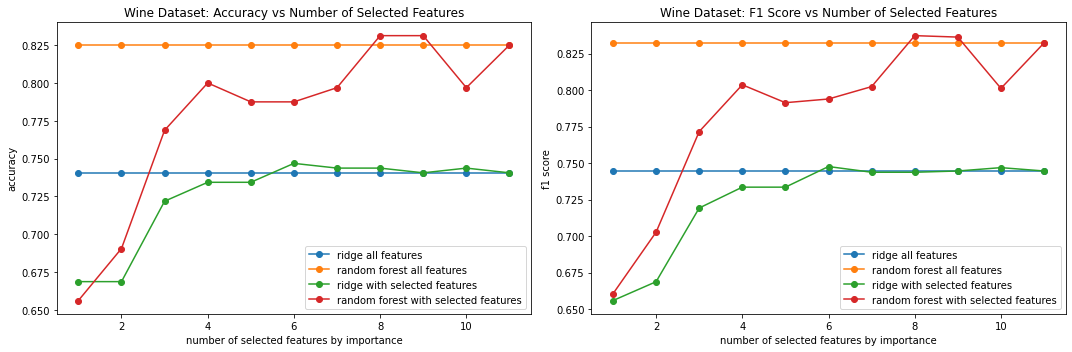

In [100]:
RF_Selection(X_wine_train, Y_wine_train, X_wine_test, Y_wine_test, "Wine")

[('Sex_female', 0.22389901293690664), ('Sex_male', 0.21529869154717943), ('Fare', 0.18615439171141046), ('Age', 0.17952987423536004), ('Pclass', 0.038878668817697457), ('SibSp', 0.03526470127803106), ('Parch', 0.034439340053743696), ('CabinType_NaN', 0.023119479217833905), ('Embarked_S', 0.010933063153709536), ('HasTitle', 0.010381714261673709), ('Embarked_C', 0.009441202000477626), ('CabinType_E', 0.006599509157332741), ('CabinType_C', 0.006132428167290348), ('CabinType_D', 0.0048242222619094), ('Embarked_Q', 0.0047601130309668244), ('CabinType_B', 0.004014156847275918), ('CabinType_F', 0.0027839789551580615), ('CabinType_A', 0.0026690575574641086), ('CabinType_G', 0.0007423498426823791), ('CabinType_T', 0.00013404496589676756)]


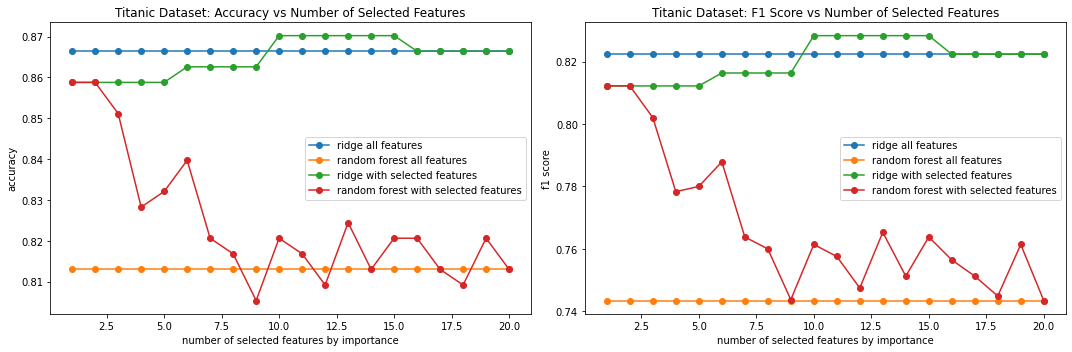

In [113]:
RF_Selection(X_titanic_train, Y_titanic_train, X_titanic_test, Y_titanic_test, "Titanic")

[('fnlwgt', 0.17846920972380392), ('age', 0.15200177027765216), ('education_num', 0.11392958081930887), ('capital_gain', 0.10537943579558007), ('hours_per_week', 0.08416219392322881), ('marital_status_ Married-civ-spouse', 0.07323946353304993), ('relationship_ Husband', 0.04857677662424341), ('capital_loss', 0.03357304473727021), ('marital_status_ Never-married', 0.020007638547550152), ('occupation_ Exec-managerial', 0.0189526314221145), ('occupation_ Prof-specialty', 0.015567832088755233), ('relationship_ Wife', 0.009388619985497027), ('workclass_ Private', 0.008932746043896543), ('relationship_ Not-in-family', 0.00858162110221229), ('relationship_ Own-child', 0.0076828444921056465), ('workclass_ Self-emp-not-inc', 0.007637785993086511), ('sex_ Male', 0.0075902945901052945), ('sex_ Female', 0.007329093871700881), ('occupation_ Other-service', 0.006794298219948686), ('race_ White', 0.006315201819378901), ('occupation_ Sales', 0.006110348628158239), ('occupation_ Craft-repair', 0.005683

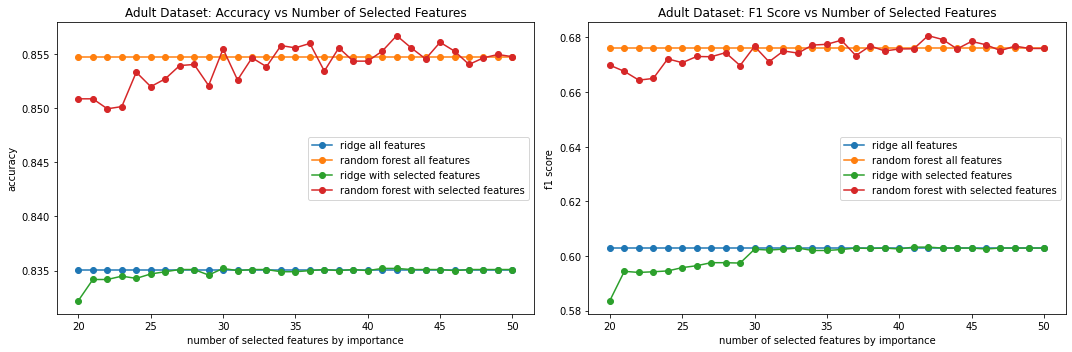

In [141]:
RF_Selection(X_adult_train, Y_adult_train, X_adult_test, Y_adult_test, "Adult", min_features = 20)

[('Humidity3pm', 0.17254816756351343), ('Pressure3pm', 0.055456532537040894), ('WindGustSpeed', 0.05440417623028645), ('Sunshine', 0.05371275335550216), ('Rainfall', 0.051406057328670686), ('Humidity9am', 0.05120262269837779), ('Pressure9am', 0.049885931900375505), ('Unnamed: 0', 0.04929458091570737), ('Temp3pm', 0.043856271260137025), ('MinTemp', 0.04189826996460715), ('Temp9am', 0.03981062420531773), ('MaxTemp', 0.039679466130084884), ('Cloud3pm', 0.03756393326723235), ('WindSpeed3pm', 0.030331611749401643), ('WindSpeed9am', 0.028030053881813986), ('RainToday', 0.02504597375194994), ('Evaporation', 0.022944821319333987), ('Cloud9am', 0.021051745713460274), ('WindDir9am_N', 0.012797105829161527), ('WindDir3pm_N', 0.01268425810435352), ('WindGustDir_W', 0.011551889186923613), ('WindDir3pm_W', 0.011459337534346272), ('WindDir9am_W', 0.011373284917343632), ('WindGustDir_N', 0.011218786776486656), ('WindGustDir_S', 0.010897709213977766), ('WindDir3pm_S', 0.010790649052251411), ('WindDir9a

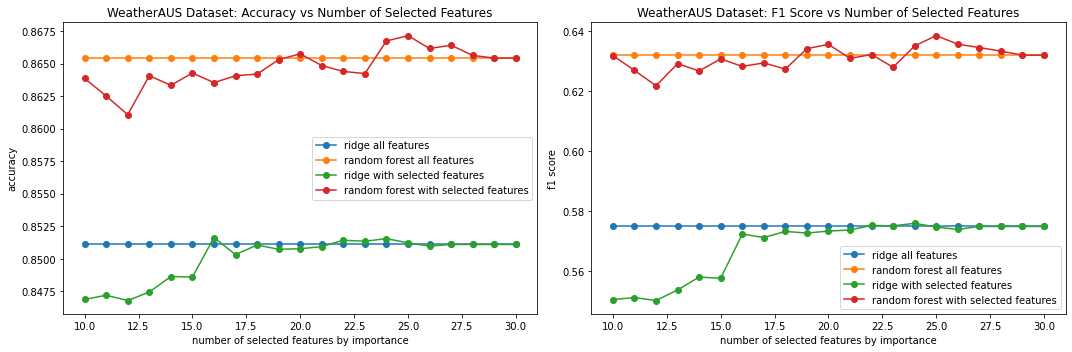

In [150]:
RF_Selection(X_weatherAUS_train, Y_weatherAUS_train, X_weatherAUS_test, Y_weatherAUS_test, "WeatherAUS", min_features = 10)

[('Humidity3pm', 0.17254816756351343), ('Pressure3pm', 0.055456532537040894), ('WindGustSpeed', 0.05440417623028645), ('Sunshine', 0.05371275335550216), ('Rainfall', 0.051406057328670686), ('Humidity9am', 0.05120262269837779), ('Pressure9am', 0.049885931900375505), ('Unnamed: 0', 0.04929458091570737), ('Temp3pm', 0.043856271260137025), ('MinTemp', 0.04189826996460715), ('Temp9am', 0.03981062420531773), ('MaxTemp', 0.039679466130084884), ('Cloud3pm', 0.03756393326723235), ('WindSpeed3pm', 0.030331611749401643), ('WindSpeed9am', 0.028030053881813986), ('RainToday', 0.02504597375194994), ('Evaporation', 0.022944821319333987), ('Cloud9am', 0.021051745713460274), ('WindDir9am_N', 0.012797105829161527), ('WindDir3pm_N', 0.01268425810435352), ('WindGustDir_W', 0.011551889186923613), ('WindDir3pm_W', 0.011459337534346272), ('WindDir9am_W', 0.011373284917343632), ('WindGustDir_N', 0.011218786776486656), ('WindGustDir_S', 0.010897709213977766), ('WindDir3pm_S', 0.010790649052251411), ('WindDir9a

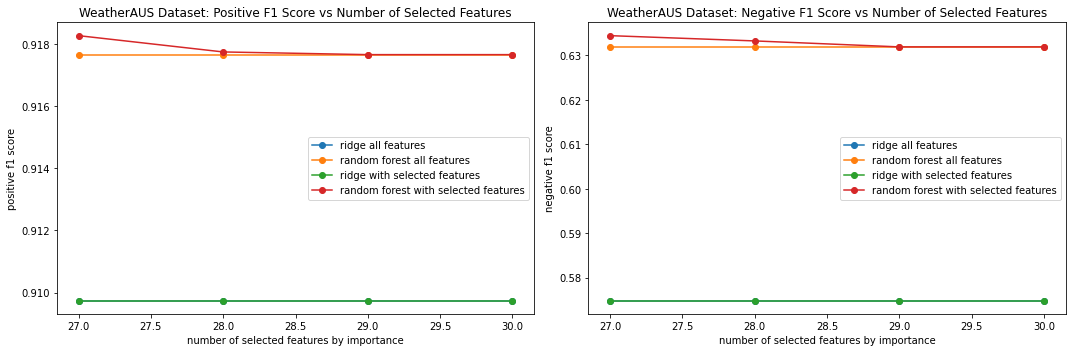

In [180]:
RF_Selection(X_weatherAUS_train, Y_weatherAUS_train, X_weatherAUS_test, Y_weatherAUS_test, "WeatherAUS", min_features = 27, negAcc=True)

# Control Burn Feature Selection

In [187]:
def CB_Selection(X_train, Y_train, X_test, Y_test, dataset_name, alpha, negAcc=False):
    cb = ControlBurnClassifier(alpha = alpha, solver = 'SCS')
    cb.fit(X_train, Y_train)
    cb_ranked_importance = rank_feature_importance(cb.features_selected_, cb.feature_importances_)

    print(cb_ranked_importance)
    print("number of features = ", len(cb_ranked_importance))
    print("number of trees = ", len(cb.forest))

    return
    all_features = list(X_train.columns)
    cb_ranked_features = [ x[0] for x in cb_ranked_importance]
    min_features = 1
    max_features = len(cb_ranked_features)
    gen_graph(X_train, X_test, all_features, cb_ranked_features, min_features, max_features, Y_train, Y_test, dataset_name, False, negAcc)

[('alcohol', 3.61431131165225), ('sulphates', 1.6104532258679496), ('volatile acidity', 1.4754141737066107), ('total sulfur dioxide', 1.0609735346709486), ('chlorides', 0.9076865996382429), ('fixed acidity', 0.5891254271449665), ('free sulfur dioxide', 0.5812188965178732), ('pH', 0.5012057368799481), ('density', 0.4632507948336298), ('residual sugar', 0.3859974032011185), ('citric acid', 0.243884381352154)]
number of features =  11
number of trees =  68


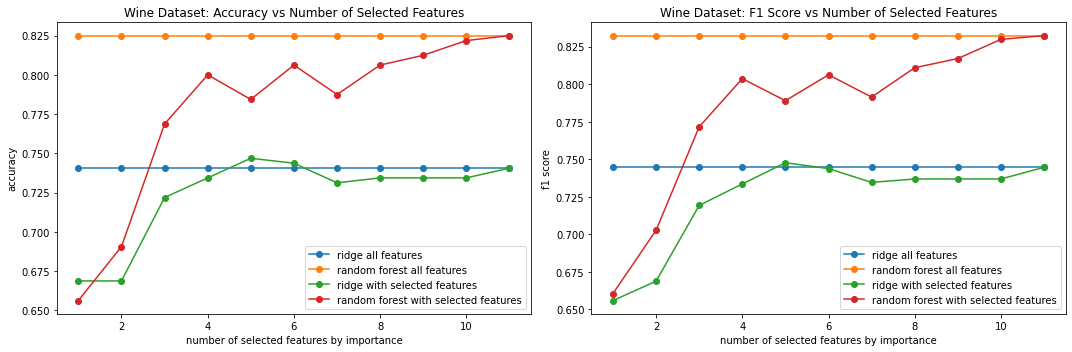

In [184]:
CB_Selection(X_wine_train, Y_wine_train, X_wine_test, Y_wine_test, "Wine", 0.001)

[('CabinType_E', 3.263321790799674), ('Sex_male', 2.953258915294276), ('HasTitle', 1.4177392543909089), ('Pclass', 1.072326715883686), ('Age', 0.5200809601512283), ('SibSp', 0.10765850434516977), ('Sex_female', 0.012801516275442687), ('Fare', 0.0), ('CabinType_NaN', 0.0)]
number of features =  9
number of trees =  39


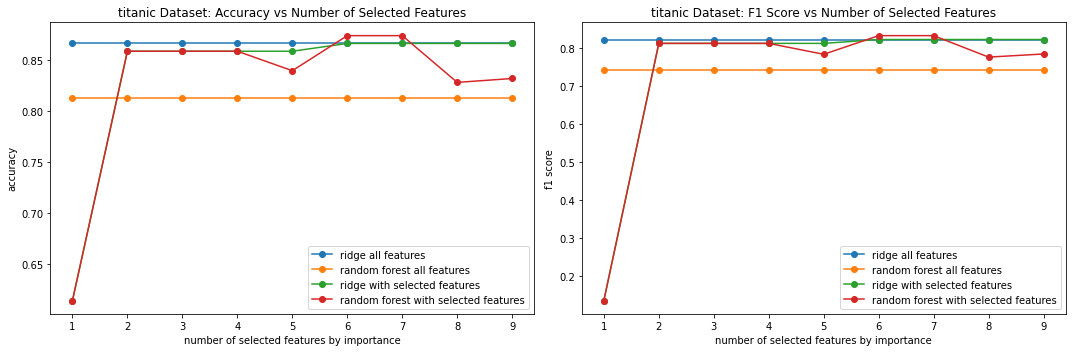

In [185]:
CB_Selection(X_titanic_train, Y_titanic_train, X_titanic_test, Y_titanic_test, "titanic", 0.001)

In [186]:
CB_Selection(X_adult_train, Y_adult_train, X_adult_test, Y_adult_test, "adult", 0.001)

(1047, 20)

In [218]:
CB_Selection(X_weatherAUS_train, Y_weatherAUS_train, X_weatherAUS_test, Y_weatherAUS_test, "weatherAUS", 0.001)

Failure:Interrupted


SolverError: Solver 'SCS' failed. Try another solver, or solve with verbose=True for more information.

# LASSO Feature Selection

In [210]:
def lasso_select_feature(alphas, X_train, Y_train):
    features_used = []
    selected_feature_set = []
    for a in alphas:
        lasso_clf = linear_model.Lasso(alpha=a, normalize=True, random_state=1, max_iter=1000000)
        lasso_clf.fit(X_train, Y_train)
        feature_filter = ~np.isclose(lasso_clf.coef_, 0)
        selected_features = select_feature(X_train.columns, feature_filter)
        if len(selected_features) > 0 and not selected_features in selected_feature_set:
            print(selected_features)
            selected_feature_set.append(selected_features)
        features_used.append(np.sum(feature_filter))
    
    plt.plot(alphas, features_used)
    plt.xlabel('alpha (L1 constant)')
    plt.ylabel('selected features')
    plt.title("LASSO feature selection")
    plt.show()
    
    return selected_feature_set

def LASSO_Selection(X_train, Y_train, X_test, Y_test, dataset_name, alphas_space, negAcc=False):
    lasso_feature_set = lasso_select_feature(alphas_space, X_train, Y_train)
    print(lasso_feature_set)
    all_features = list(X_train.columns)
    min_features = 1
    max_features = len(all_features)
    gen_graph(X_train, X_test, all_features, lasso_feature_set, min_features, max_features, Y_train, Y_test, dataset_name, True, negAcc)
    


No handles with labels found to put in legend.


['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'alcohol']
['alcohol']


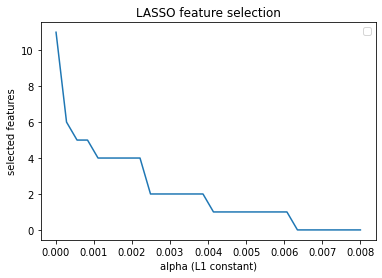

[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'], ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol'], ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol'], ['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol'], ['volatile acidity', 'alcohol'], ['alcohol']]


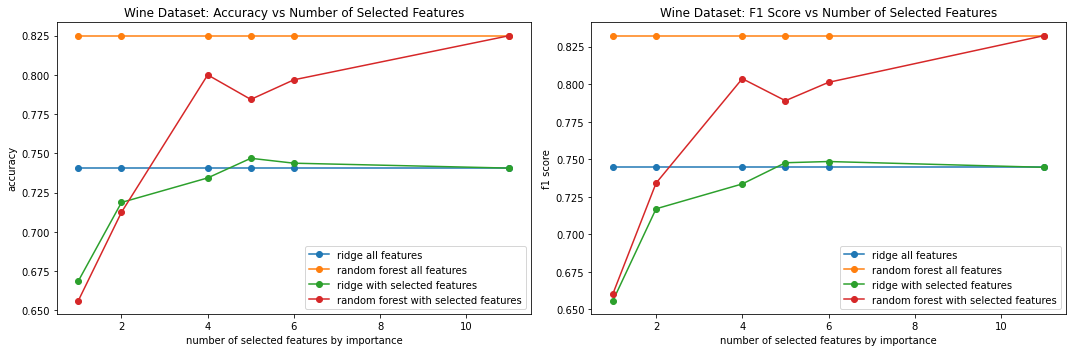

In [208]:
LASSO_Selection(X_wine_train, Y_wine_train, X_wine_test, Y_wine_test, "Wine", np.linspace(0.00001,0.008,30))

No handles with labels found to put in legend.


['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_A', 'CabinType_C', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_G', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_NaN', 'Embarked_C', 'Embarked_S']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_NaN', 'Embarked_C']
['Pclass', 'Age', 'SibSp', 'HasTitle', 'Sex_female', 'CabinType_NaN', 'Embarked_C']
['Pclass', 'SibSp', 'HasTitle', 'Sex_female', 'CabinType_NaN', 'Embarked_C']
['Pclass', 'HasTitle', 'Sex_female', 'CabinType_NaN']
['Pclass', 'Sex_female', 'CabinType_NaN']
['Sex_female']


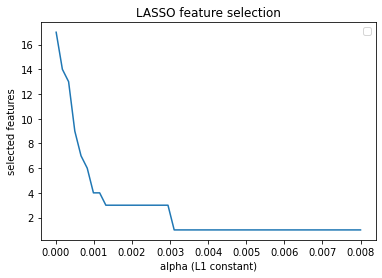

[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_A', 'CabinType_C', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_G', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S'], ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_NaN', 'CabinType_T', 'Embarked_C', 'Embarked_S'], ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_D', 'CabinType_E', 'CabinType_F', 'CabinType_NaN', 'Embarked_C', 'Embarked_S'], ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'HasTitle', 'Sex_female', 'CabinType_NaN', 'Embarked_C'], ['Pclass', 'Age', 'SibSp', 'HasTitle', 'Sex_female', 'CabinType_NaN', 'Embarked_C'], ['Pclass', 'SibSp', 'HasTitle', 'Sex_female', 'CabinType_NaN', 'Embarked_C'], ['Pclass', 'HasTitle', 'Sex_female', 'CabinType_NaN'], ['Pclass', 'Sex_female', 'CabinType_NaN'], ['Sex_female']]


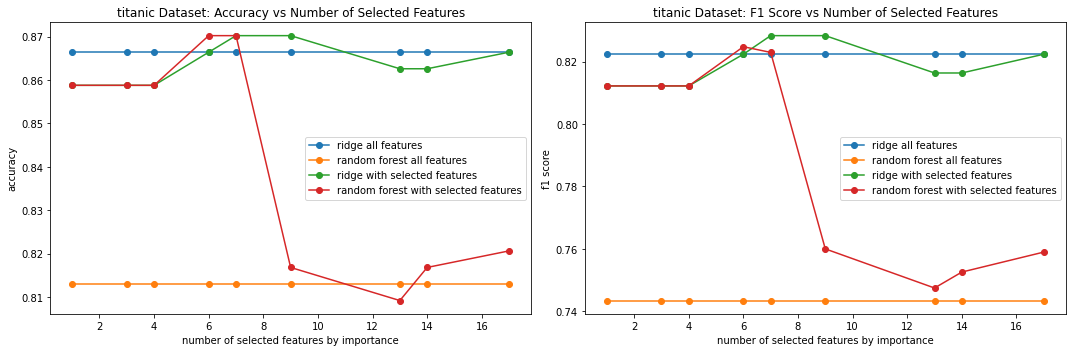

In [214]:
LASSO_Selection(X_titanic_train, Y_titanic_train, X_titanic_test, Y_titanic_test, "titanic", np.linspace(0.00001,0.008,50))

['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'marital_status_ Divorced', 'marital_status_ Married-AF-spouse', 'marital_status_ Married-civ-spouse', 'marital_status_ Married-spouse-absent', 'marital_status_ Never-married', 'occupation_ Adm-clerical', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'occupation_ Transport-moving', 'relationship_ Husband', 'relationship_ Not-in-family', 'relationship_ Unmarried', 'relationship_ Wife', 'race_ White', 'sex_ Female']
['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'workclass_ Federal-gov', 'workclass_ Self-emp-inc', 'w

No handles with labels found to put in legend.


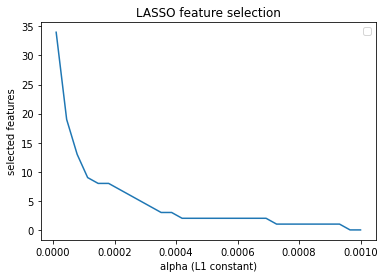

[['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'marital_status_ Divorced', 'marital_status_ Married-AF-spouse', 'marital_status_ Married-civ-spouse', 'marital_status_ Married-spouse-absent', 'marital_status_ Never-married', 'occupation_ Adm-clerical', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct', 'occupation_ Other-service', 'occupation_ Prof-specialty', 'occupation_ Protective-serv', 'occupation_ Sales', 'occupation_ Tech-support', 'occupation_ Transport-moving', 'relationship_ Husband', 'relationship_ Not-in-family', 'relationship_ Unmarried', 'relationship_ Wife', 'race_ White', 'sex_ Female'], ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'workclass_ Federal-gov', 'workclass_ Self-emp-inc', 

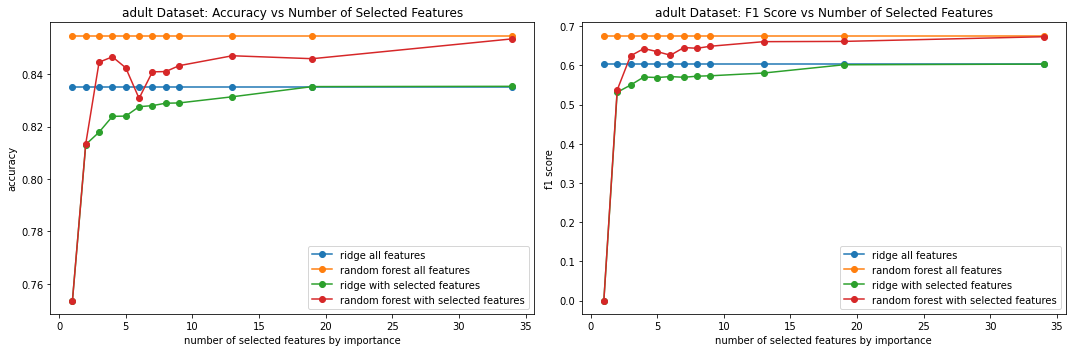

In [216]:
LASSO_Selection(X_adult_train, Y_adult_train, X_adult_test, Y_adult_test, "adult", np.linspace(0.00001,0.001,30))

['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_E']
['Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday', 'WindDir9am_N', 'WindDir9am_S', 'WindDir3pm_N']
['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday', 'WindDir9am_N']
['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday']
['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday']
['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'RainToday']
['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'RainToday']
['Humidity3pm']


No handles with labels found to put in legend.


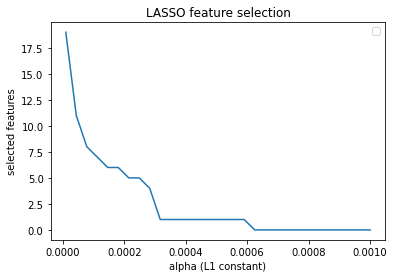

[['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_E'], ['Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday', 'WindDir9am_N', 'WindDir9am_S', 'WindDir3pm_N'], ['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday', 'WindDir9am_N'], ['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday'], ['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm', 'RainToday'], ['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'RainToday'], ['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'RainToday'], ['Humidity3pm']]


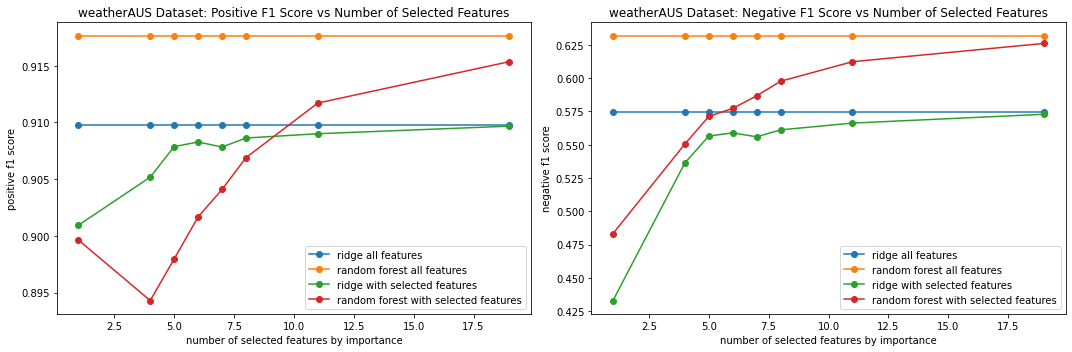

In [217]:
LASSO_Selection(X_weatherAUS_train, Y_weatherAUS_train, X_weatherAUS_test, Y_weatherAUS_test, "weatherAUS", np.linspace(0.00001,0.001,30), negAcc=True)